# FROMAGe Visual Alignment Analysis
## (https://arxiv.org/abs/2301.13823)

### Imports

In [1]:
import copy
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from transformers import logging, GPT2Tokenizer
logging.set_verbosity_error()
from fromage.models import FromageModel
from fromage import utils
from collections import namedtuple
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial import distance
import plotly.express as px

In [2]:
model_dir = './fromage_model/'
model_args_path = os.path.join(model_dir, 'model_args.json')
model_ckpt_path = os.path.join(model_dir, 'pretrained_ckpt.pth.tar')
with open(model_args_path, 'r') as f:
  model_kwargs = json.load(f)

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained(model_kwargs['opt_version'])
tokenizer.pad_token = tokenizer.eos_token
# Add special tokens to the model to enable [RET].
tokenizer.add_special_tokens({"cls_token": "<|image|>"})
tokenizer.add_tokens('[RET]')
ret_token_idx = tokenizer('[RET]', add_special_tokens=False).input_ids
assert len(ret_token_idx) == 1, ret_token_idx
model_kwargs['retrieval_token_idx'] = ret_token_idx[0]
args = namedtuple('args', model_kwargs)(**model_kwargs)

### Load Model

In [4]:
model = FromageModel(tokenizer=tokenizer, args=args)
model.eval()
model.half()
model.cpu()

Using HuggingFace AutoFeatureExtractor for openai/clip-vit-large-patch14.


C:\ProgramData\Anaconda3\envs\power\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Using facebook/opt-6.7b for the language model.
Using openai/clip-vit-large-patch14 for the visual model with 1 visual tokens.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Freezing the LM.
Initializing embedding for the retrieval token [RET] (id = 50266).
Restoring pretrained weights for the visual model.
Freezing the VM.


FromageModel(
  (lm): OPTForCausalLM(
    (model): OPTModel(
      (decoder): OPTDecoder(
        (embed_tokens): Embedding(50267, 4096)
        (embed_positions): OPTLearnedPositionalEmbedding(2050, 4096)
        (final_layer_norm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0): OPTDecoderLayer(
            (self_attn): OPTAttention(
              (k_proj): Linear(in_features=4096, out_features=4096, bias=True)
              (v_proj): Linear(in_features=4096, out_features=4096, bias=True)
              (q_proj): Linear(in_features=4096, out_features=4096, bias=True)
              (out_proj): Linear(in_features=4096, out_features=4096, bias=True)
            )
            (activation_fn): ReLU()
            (self_attn_layer_norm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
            (fc1): Linear(in_features=4096, out_features=16384, bias=True)
            (fc2): Linear(in_features=16384, out_features=4096, bias=True)
 

In [5]:
def remove_model_from_ckpt(d):
    new_dict = {}
    for key, value in zip(d.keys(), d.values()):
        if 'model' in key:
            new_key = key.split('model.')[-1]
        else:
            new_key = key
        new_dict[new_key] = d[key]
    return new_dict

In [6]:
checkpoint = torch.load(model_ckpt_path, map_location=torch.device('cpu'))
checkpoint['state_dict'] = remove_model_from_ckpt(checkpoint['state_dict'])
_ = model.load_state_dict(checkpoint['state_dict'], strict=False)

In [7]:
#no_projection
def get_visual_embeddings(inp_image, mode='captioning', device='cpu', batch_size=-1):
    if mode == 'captioning':
        EMB_SIZE = 4096
    else:
        EMB_SIZE = 1024
    model.visual_model.eval().to(device)
    model.visual_embeddings.eval().to(device)
    
    if not isinstance(inp_image, list):
        inp_image = [inp_image]
        
    if batch_size == -1:
        batch_size = len(inp_image)
    
    if len(inp_image) / batch_size > len(inp_image) // batch_size:
        one_more = True
        remainder = len(inp_image) % batch_size
    else:
        one_more = False
        remainder = 0
    
    iterations = len(inp_image) // batch_size
    results = torch.empty(size=(len(inp_image), EMB_SIZE))
    i = 0
    for i in range(iterations):
        storage = []
        slice_ = inp_image[i*batch_size:(i+1)*batch_size]
        for image in slice_:
            storage.append(utils.get_pixel_values_for_model(model.feature_extractor, image)[None,...])

        pixel_values = torch.concat(storage)
        pixel_values = pixel_values.to(device=device, dtype=model.logit_scale.dtype)

        with torch.no_grad():
            visual_embs = model.get_visual_embs(pixel_values, mode=mode)
        #print(f"Side of left OP: {results[i*batch_size:(i+1)*batch_size, :].size()}")
        #print(f"Side of right OP: {visual_embs.reshape(batch_size, 4096).cpu().size()}")
        results[i*batch_size:(i+1)*batch_size, :] = visual_embs.reshape(batch_size, EMB_SIZE).cpu()
    if one_more:
        storage = []
        slice_ = inp_image[i*batch_size:i*batch_size + remainder]
        for image in slice_:
            storage.append(utils.get_pixel_values_for_model(model.feature_extractor, image)[None,...])

        pixel_values = torch.concat(storage)
        pixel_values = pixel_values.to(device=device, dtype=model.logit_scale.dtype)

        with torch.no_grad():
            visual_embs = model.get_visual_embs(pixel_values, mode=mode)
        #print(f"Side of left OP: {results[i*batch_size:(i+1)*batch_size, :].size()}")
        #print(f"Side of right OP: {visual_embs.reshape(batch_size, 4096).cpu().size()}")
        results[i*batch_size:i*batch_size + remainder, :] = visual_embs.reshape(remainder, EMB_SIZE).cpu()
        
#     if device == 'cuda':
#         torch.cuda.empty_cache()
    return results

### Embedding Experiments

In [ ]:
LLM_embedding_matrix = model.lm.model.decoder.embed_tokens.weight # OPT 6.7B Embedding Matrix
LLM_embedding_matrix = torch.Tensor(LLM_embedding_matrix.detach())
LLM_embedding_matrix.requires_grad = False

### Lets produce position 1 embeddings for all words

In [ ]:
#LLM_embedding_matrix +=  model.lm.model.decoder.embed_positions(torch.ones(size=(1,2)))[0,1,:]

### Post Layer 1 Embedding Experiments

In [10]:
def get_embedding_similarity(a, top_k=20, verbose=True, low_rank=None, add_fuse_token=None, post_fuse_norm=False):
    ### Returns the similarity between an embedding and the embedding matrix ###
    ### Returns the top k (default k = 20) most similar tokens ###
    if isinstance(a, np.ndarray):
        a = torch.Tensor(a)
    if low_rank is not None:
        matrix = copy.deepcopy(low_rank)
    else:
        matrix = copy.deepcopy(LLM_embedding_matrix)
        
    if add_fuse_token is not None:
        if '-' in add_fuse_token:
            fuse_index = int(add_fuse_token[1:])
            func = lambda x: -x
        elif '+' in add_fuse_token:
            fuse_index = int(add_fuse_token[1:])
            func = lambda x: x
        else:
            fuse_index = int(add_fuse_token)
            func = lambda x: x
        
        emb = func(matrix[fuse_index])
        matrix = matrix + emb
    
    if post_fuse_norm:
        matrix = torch.div(matrix, torch.norm(matrix, p=1, dim=1, keepdim=True))
        
    similarity = torch.nn.CosineSimilarity(dim=1)(a,matrix)
    index_sorted = torch.argsort(similarity, descending=True)
    top = index_sorted
    if top_k != -1:
        top = top[:top_k]
    decoded_top = tokenizer.batch_decode(top)
    if verbose:
        print(decoded_top)
    return top, decoded_top

In [11]:
def get_dp_similarity(a, top_k=20, verbose=True, low_rank=None, add_fuse_token=None, post_fuse_norm=False):
    ### Returns the dot product between an embedding and the embedding matrix ###
    ### Returns the top k (default k = 20) most similar tokens ###
    if isinstance(a, np.ndarray):
        a = torch.Tensor(a)
    if low_rank is not None:
        matrix = copy.deepcopy(low_rank)
    else:
        matrix = copy.deepcopy(LLM_embedding_matrix)
        
    if add_fuse_token is not None:
        if '-' in add_fuse_token:
            fuse_index = int(add_fuse_token[1:])
            func = lambda x: -x
        elif '+' in add_fuse_token:
            fuse_index = int(add_fuse_token[1:])
            func = lambda x: x
        else:
            fuse_index = int(add_fuse_token)
            func = lambda x: x
        
        emb = func(matrix[fuse_index])
        matrix = matrix + emb
    
    if post_fuse_norm:
        matrix = torch.div(matrix, torch.norm(matrix, p=1, dim=1, keepdim=True))
        
    score = matrix @ a.T
   
    #score = score[:,0]
    index_sorted = torch.argsort(score, descending=True)
    top = index_sorted
    if top_k != -1:
        top = top[:top_k]
    decoded_top = tokenizer.batch_decode(top)
    if verbose:
        print(decoded_top)
    return top, decoded_top

In [12]:
def get_eucledian_similarity(a, norm=2, top_k=20, verbose=True, low_rank=None, add_fuse_token=None, post_fuse_norm=False):
    ### Returns the reverse distance between an embedding and the embedding matrix ###
    ### Returns the top k (default k = 20) most close tokens ###
    if isinstance(a, np.ndarray):
        a = torch.Tensor(a)
    if low_rank is not None:
        matrix = copy.deepcopy(low_rank)
    else:
        matrix = copy.deepcopy(LLM_embedding_matrix)
        
    if add_fuse_token is not None:
        if '-' in add_fuse_token:
            fuse_index = int(add_fuse_token[1:])
            func = lambda x: -x
        elif '+' in add_fuse_token:
            fuse_index = int(add_fuse_token[1:])
            func = lambda x: x
        else:
            fuse_index = int(add_fuse_token)
            func = lambda x: x
        
        emb = func(matrix[fuse_index])
        matrix = matrix + emb
    
    if post_fuse_norm:
        matrix = torch.div(matrix, torch.norm(matrix, p=1, dim=1, keepdim=True))
        

    distance = torch.cdist(matrix, a[None,...], p=norm)
    distance = torch.flatten(distance)
    index_sorted = torch.argsort(distance, descending=False)
    top = index_sorted
    if top_k != -1:
        top = top[:top_k]
    decoded_top = tokenizer.batch_decode(top)
    if verbose:
        print(decoded_top)
    return top, decoded_top

In [13]:
def get_word_rank(a, word, low_rank=None, add_fuse_token=None, post_fuse_norm=False):
    _, decoded_tops_cos = get_embedding_similarity(a, -1, False, low_rank=low_rank, add_fuse_token=add_fuse_token, post_fuse_norm=post_fuse_norm)
    _, decoded_tops_dp = get_dp_similarity(a, -1, False, low_rank=low_rank, add_fuse_token=add_fuse_token, post_fuse_norm=post_fuse_norm)
    _, decoded_tops_l2 = get_eucledian_similarity(a, 2, -1, False, low_rank=low_rank, add_fuse_token=add_fuse_token, post_fuse_norm=post_fuse_norm)
    (rank_cos, rank_dp, rank_euc) = (-1, -1, -1)
    
    for i, x in enumerate(decoded_tops_cos):
        if word.lower() == x.strip().lower():
            #print(f"Cosine Similarity Rank: {i}")
            rank_cos = i
            break
            
    for i, x in enumerate(decoded_tops_dp):
        if word.lower() == x.strip().lower():
            #print(f"Cosine Similarity Rank: {i}")
            rank_dp = i
            break
            
    for i, x in enumerate(decoded_tops_l2):
        if word.lower() == x.strip().lower():
            #print(f"L2 Norm Rank: {i}")
            rank_euc = i
            break
    return rank_cos, rank_dp, rank_euc

### SVD Decomposition

In [ ]:
def low_rank_approx(a=None, r=1):
    """
    Computes an r-rank approximation of a matrix
    given the component u, s, and v of it's SVD
    Requires: numpy
    """

    u, s, v = np.linalg.svd(a, full_matrices=False)
    Ar = np.zeros((len(u), len(v)))
    for i in range(r):
        Ar += s[i] * np.outer(u.T[i], v[i])
    return Ar

In [ ]:
# # Random Matrix
# rm = LLM_embedding_matrix.numpy()

In [ ]:
# rm.shape

In [ ]:
# aprx = low_rank_approx(rm,r=1000)

In [ ]:
# aprx = torch.Tensor(aprx)

In [ ]:
# aprx.size()

In [ ]:
# aprx_l1 = torch.nn.functional.normalize(aprx, p=1, dim=1)
# aprx_l2 = torch.nn.functional.normalize(aprx, p=2, dim=1)

### Experiments with CIFAR-100

In [ ]:
from datasets import load_dataset
dataset = load_dataset("cifar100", split='train')

In [ ]:
dataset = dataset.sort(column='coarse_label')

In [ ]:
label_fish = dataset.filter(lambda example: example["coarse_label"] == 1) #fish
label_flower = dataset.filter(lambda example: example["coarse_label"] == 2) #flowers
label_people = dataset.filter(lambda example: example["coarse_label"] == 14) # people
label_fruit_and_veg = dataset.filter(lambda example: example["coarse_label"] == 4) # fruit_and_vegetables
label_vechicles = dataset.filter(lambda example: example["coarse_label"] == 19) # vechicles
label_small_animals = dataset.filter(lambda example: example["coarse_label"] == 16) # small animals

In [ ]:
label_fish = dataset.filter(lambda example: example["fine_label"] == 1)

In [ ]:
label_fish

In [ ]:
for i in range(500):
    plt.imshow(label_fish[i]['img'])
    plt.show()

In [ ]:
set(label_fruit_and_veg['fine_label'])

In [ ]:
# 2: baby
# 11: boy 500
# 35: girl 500
# 46: man 500
# 98: woman 500

In [ ]:
list(filter(lambda x: x==98, label_people['fine_label'])).__len__()

In [ ]:
### Create Clusters from 200 images

In [ ]:
SIZE_OF_CLUSTERS = 50

In [ ]:
from PIL import Image

img = Image.new('RGB', (224, 224), (255, 255, 255))
img.show()

In [ ]:
def create_single_color_images(n=1, color='black'):
    assert color in ['blue','red','green','white','black','noise']
    if color == 'blue':
        RGB_vals = (0, 0, 255)
    elif color == 'red':
        RGB_vals = (255, 0, 0)
    elif color == 'green':
        RGB_vals = (0, 255, 0)
    elif color == 'black':
        RGB_vals = (0, 0, 0)
    elif color == 'white':
        RGB_vals = (255, 255, 255)
    elif color == 'noise':
        return [Image.fromarray(np.random.randint(0,255,(224,224,3),dtype=np.dtype('uint8'))) for _ in range(n)]
    else:
        pass
    
    return Image.new('RGB', (224, 224), RGB_vals)

In [ ]:
create_single_color_images(color='noise')[0]

In [ ]:
#flower_centroid = get_visual_embeddings(label_flower['img'], batch_size=50, device='cuda').mean(dim=0)
#people_centroid = get_visual_embeddings(label_people['img'], batch_size=50, device='cuda').mean(dim=0)
#animal_centroid = get_visual_embeddings(label_small_animals['img'], batch_size=50, device='cuda').mean(dim=0)
fruit_centroid = get_visual_embeddings(label_fruit_and_veg['img'], batch_size=50, device='cuda').mean(dim=0)
fish_centroid = get_visual_embeddings(label_fish['img'], batch_size=50, device='cuda').mean(dim=0)
# fnv_centroid = np.zeros(shape=(1,4096))
# for i in range(SIZE_OF_CLUSTERS):
#     ve_i = get_visual_embeddings(label_fruit_and_veg[i]['img'])
#     fnv_centroid += ve_i.numpy()
# fnv_centroid = fnv_centroid / SIZE_OF_CLUSTERS
# vechicle_centroid = np.zeros(shape=(1,4096))
# for i in range(SIZE_OF_CLUSTERS):
#     ve_i = get_visual_embeddings(label_vechicles[i]['img'])
#     vechicle_centroid += ve_i.numpy()
# vechicle_centroid = vechicle_centroid / SIZE_OF_CLUSTERS
# fish_centroid = np.zeros(shape=(1,4096))
# for i in range(SIZE_OF_CLUSTERS):
#     ve_i = get_visual_embeddings(label_fish[i]['img'])
#     fish_centroid += ve_i.numpy()
# fish_centroid = fish_centroid / SIZE_OF_CLUSTERS


In [ ]:
white_centroid = get_visual_embeddings(create_single_color_images(color='white'), batch_size=1, device='cpu')

In [ ]:
black_centroid = get_visual_embeddings(create_single_color_images(color='black'), batch_size=1, device='cpu')

In [ ]:
random_centroid = get_visual_embeddings(create_single_color_images(n=2, color='noise'), batch_size=2, device='cpu')

In [ ]:
random_centroid = random_centroid.mean(dim=0)[None,...]

In [ ]:
black_centroid.size()

In [ ]:
### Global Text Centroid ###
global_centroid = np.mean(LLM_embedding_matrix.numpy(), axis=0).reshape(1,4096)

In [ ]:
global_centroid.shape

In [ ]:
people_centroid.size()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [ ]:
n_bins = 100

# Generate 3 
dist1 = global_centroid[0]
dist2 = random_centroid[0].numpy()
dist3 = people_centroid.numpy()
dist4 =animal_centroid.numpy()

fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True, figsize=(15, 15))

axs[0].hist(dist1, bins=n_bins)
axs[1].hist(dist2, bins=n_bins)
axs[2].hist(dist3, bins=n_bins)
axs[3].hist(dist4, bins=n_bins)
axs[0].title.set_text('OPT 6.7 \nembs')
axs[1].title.set_text('Random Noise Image \nembs')
axs[2].title.set_text('People Image \nembs')
axs[3].title.set_text('Animal Image \nembs')
plt.savefig('difference.png')
plt.show()

### Cluster Similarities

In [ ]:
WordChecklist = {
#     'fish': {},
     'animal': {},
#     'water':{},
#     'sea':{},
#     'blue':{},
     'flower':{},
#     'plant':{},
#     'pedal':{},
#     'earth':{},
#     'green':{},
    '</s>':{},
    'tree':{},
     'man':{},
#     'woman':{},
#     'child':{},
#     'people':{},
#     'person':{},
#     'fruit':{},
#     'vegetable':{},
#     'plant':{},
#     'green':{},
#     'car':{},
#     'auto':{},
#     'vehicle':{},
#     'bike':{},
#     'rat':{},
#     'mouse':{},
#     'hamster':{},
#     'small':{},
#     'squirrel':{}
}

In [ ]:
def experiment_of_similarities(wordchecklist=None,
                               modulate_cluster_token=-1,
                               add_fuse_token=-1,
                               post_fuse_norm=False):
    for cluster in [#('fish',fish_centroid),
                #('flower',flower_centroid),
                #('people', people_centroid),
                #('fnv', fnv_centroid),
                #('veh', vechicle_centroid),
                #('sanim', animal_centroid),
                ('black', black_centroid)
               ]:
        if modulate_cluster_token > -1:
            modulator = copy.deepcopy(LLM_embedding_matrix[modulate_cluster_token])
        for word in wordchecklist.keys():
            if modulate_cluster_token > -1:
                mod_a = torch.Tensor(cluster[1]) - modulator
            else:
                mod_a = torch.Tensor(cluster[1])
                
            
            rank_cos, rank_dp, rank_euc = get_word_rank(a=mod_a, word=word, low_rank=None, add_fuse_token=add_fuse_token, post_fuse_norm=post_fuse_norm)
            wordchecklist[word].update({f'cluster_{cluster[0]}': {'cos_rank': rank_cos, 'euc_rank': rank_euc, 'dp_rank':rank_dp}})
    ## COS
    data_pd = pd.DataFrame(wordchecklist)
    data_pd_ = data_pd.applymap(lambda x: int(dict(x)['cos_rank']))
    ordered_slice = pd.DataFrame(data=data_pd_.min().sort_values())
    ordered_slice = ordered_slice.reset_index()
    ordered_slice['tokenized'] = ordered_slice['index'].apply(lambda x: list(tokenizer.encode(x)))
    ordered_slice['tokenized_len'] = ordered_slice['tokenized'].apply(lambda x: x.__len__())
    ordered_slice = ordered_slice[ordered_slice['tokenized_len'] == 2]
    ordered_slice_cos = ordered_slice.rename(columns={0:'cos_distance'})
    
    ## DP
    data_pd = pd.DataFrame(wordchecklist)
    data_pd_ = data_pd.applymap(lambda x: int(dict(x)['dp_rank']))
    ordered_slice = pd.DataFrame(data=data_pd_.min().sort_values())
    ordered_slice = ordered_slice.reset_index()
    ordered_slice['tokenized'] = ordered_slice['index'].apply(lambda x: list(tokenizer.encode(x)))
    ordered_slice['tokenized_len'] = ordered_slice['tokenized'].apply(lambda x: x.__len__())
    ordered_slice = ordered_slice[ordered_slice['tokenized_len'] == 2]
    ordered_slice_dp = ordered_slice.rename(columns={0:'dp_distance'})
    
    ## EUC
    data_pd = pd.DataFrame(wordchecklist)
    data_pd_ = data_pd.applymap(lambda x: int(dict(x)['euc_rank']))
    ordered_slice = pd.DataFrame(data=data_pd_.min().sort_values())
    ordered_slice = ordered_slice.reset_index()
    ordered_slice['tokenized'] = ordered_slice['index'].apply(lambda x: list(tokenizer.encode(x)))
    ordered_slice['tokenized_len'] = ordered_slice['tokenized'].apply(lambda x: x.__len__())
    ordered_slice = ordered_slice[ordered_slice['tokenized_len'] == 2]
    ordered_slice_euc = ordered_slice.rename(columns={0:'euc_distance'})
    return ordered_slice_cos, ordered_slice_dp, ordered_slice_euc

In [ ]:
torch.cuda.empty_cache()

### Normal Experiment

In [ ]:
normal_frame_cos, normal_frame_dp, normal_frame_euc = experiment_of_similarities(copy.deepcopy(WordChecklist), modulate_cluster_token=-1, add_fuse_token=None, post_fuse_norm=False)

In [ ]:
normal_frame_cos

In [ ]:
normal_frame_dp

In [ ]:
normal_frame_euc

### Additive FUSE \</s> --> Idea add \</s> (token nr.2) and recalculate embedding similarity

#### V1: No Norm

In [ ]:
add_frame_cos, add_frame_dp, add_frame_euc = experiment_of_similarities(copy.deepcopy(WordChecklist),modulate_cluster_token=-1, add_fuse_token='2', post_fuse_norm=False)

In [ ]:
add_frame_cos

In [ ]:
add_frame_dp

In [ ]:
add_frame_euc

#### V2: Norm

In [ ]:
add_frame_cos_n, add_frame_dp_n, add_frame_euc_n = experiment_of_similarities(copy.deepcopy(WordChecklist),modulate_cluster_token=-1, add_fuse_token='+2', post_fuse_norm=True)

In [ ]:
add_frame_cos_n

In [ ]:
add_frame_dp_n

In [ ]:
add_frame_euc_n

### Subtractive FUSE \</s> --> Idea subtract \</s> (token nr.2) from visual token and recalc

In [ ]:
sub_frame_cos, sub_frame_dp, sub_frame_euc = experiment_of_similarities(copy.deepcopy(WordChecklist),modulate_cluster_token=2, add_fuse_token='-1', post_fuse_norm=False)

In [ ]:
sub_frame_cos

In [ ]:
sub_frame_dp

In [ ]:
sub_frame_euc

In [ ]:
###

In [ ]:
#inp = tokenizer.encode('Repeat the word apple to me.', return_tensors='pt')

In [ ]:
#oup = model.lm.generate(inp, max_new_tokens=2, return_dict_in_generate=True, output_hidden_states=True)

In [ ]:
#prompted_next_word = [f[0][0] for f in oup.hidden_states[1]]

### Can we invert language tokens to visual tokens? Not really...

In [ ]:
# W = model.visual_embeddings.weight
# W.requires_grad = False
# b = model.visual_embeddings.bias
# b.requires_grad = False
# import numpy
# W_inv = numpy.linalg.pinv(W.numpy())
# (W @ W_inv).mean()
# LLM_embedding_matrix.shape
# W_inv.shape
# LLM_embedding_matrix_inv = (LLM_embedding_matrix - b) @ W_inv.T
# LLM_embedding_matrix_inv.shape
# LLM_embedding_matrix_inv.mean()

### Layer FUSE --> Idea add \</s> (token nr.2) and pass token through 1 layer?

In [ ]:
def get_llm_embeds(words=None, add_s=True):
    save_dict = {k:[] for k in words}
    with torch.no_grad():
        for word in words:
            inps = tokenizer.encode(word, return_tensors='pt')
            start_idx = 1
            if add_s == False:
                start_idx = 0
                inps = inps[:,1:]
            output = model.lm(inps, output_hidden_states=True)
            save_dict[word].append([output.hidden_states[i][0,start_idx,:] for i in range(len(output.hidden_states))])
    save_dict = {k:v[0] for k,v in save_dict.items()}
    return save_dict

In [ ]:
visual_emb = black_centroid

In [ ]:
def get_mixed_llm_embeds(visual_emb=None, text_emb=None, text=None):
    with torch.no_grad():
        if text is not None:
            text_id = tokenizer.encode(text, return_tensors='pt')
            text_emb = model.lm.model.decoder.embed_tokens(text_id) #+ model.lm.model.decoder.embed_positions(torch.ones_like(text_id))
        else:
            pass
        if visual_emb is not None:
            if not isinstance(visual_emb, list):
                embs = torch.concat([visual_emb[None,...], text_emb], dim=1)
            else:
                emb = [ve[None,...] for ve in visual_emb]
                emb.append(text_emb)
                embs = torch.concat(emb, dim=1)
        else:
            embs =  text_emb
    return embs

In [ ]:
def calc_embedding_change(og_embed, emb_mat_list):
    """
        Gets as input a list of tensors and need to calculate the inbetween l2_norm differences
    """
    total_number = len(emb_mat_list)
    similarity_change = []
    norm_change = []
    for i in range(total_number):
        sim = torch.nn.CosineSimilarity(dim=0)(og_embed, emb_mat_list[i])
        #sim = og_embed @ emb_mat_list[i].T
        diff = torch.norm(
            (emb_mat_list[i] - og_embed),
            p=2)
        similarity_change.append(sim)
        norm_change.append(diff)
    return similarity_change, norm_change    

### Lets try the extraction experiment

In [ ]:
inp_image_apple = utils.get_image_from_url(
    'https://media.istockphoto.com/id/184276818/photo/red-apple.jpg?s=612x612&w=0&k=20&c=NvO-bLsG0DJ_7Ii8SSVoKLurzjmV0Qi4eGfn6nW3l5w='
)
plt.imshow(inp_image_apple)
apple_vector = get_visual_embeddings(inp_image_apple)

In [ ]:
### Step 1: Get an centroid e.g humans
visual_embedding = apple_vector

In [ ]:
### Step 2: Join in with a potential caption or another image

In [ ]:
mixed_embs = get_mixed_llm_embeds(visual_emb = visual_embedding, text='Picture of an')
print(f"Total seq length: {mixed_embs.size()[1]}")

In [ ]:
### Step 3: Pass it through all layers and get the hidden states
with torch.no_grad():
    output = model.lm(inputs_embeds=mixed_embs, output_hidden_states=True)

In [ ]:
hidden_states_org = [output.hidden_states[i][0,:,:] for i in range(len(output.hidden_states))]

In [ ]:
img_hs = [f[0,:] for f in hidden_states_org]
img_plus_start_hs = [f[1,:] for f in hidden_states_org]
man_hs =  [f[2,:] for f in hidden_states_org]
tree_hs =  [f[3,:] for f in hidden_states_org]
dog_hs =  [f[4,:] for f in hidden_states_org]

In [ ]:
### IS ANY HS in the normal range of an embedding? -> Not really

In [ ]:
def fast_cossim(x):
    cos = lambda m: F.normalize(m, p=2, dim=-1) @ F.normalize(m, p=2, dim=-1).t()
    return torch.stack([cos(m) for m in x])

In [ ]:
def fast_ecd(x):
    return torch.cdist(x,x,p=2)

In [ ]:
import torch.nn.functional as F

In [ ]:
for i in range(33):
    print(f"Layer {i}:")
    print(fast_ecd(hidden_states_org[i][None,...]))
    print(fast_cossim(hidden_states_org[i][None,...]))

In [ ]:
### Removing the image

In [ ]:
mixed_embs = get_mixed_llm_embeds(visual_emb = black_centroid, text='Picture of an')

In [ ]:
print(f"Total seq length: {mixed_embs.size()[1]}")
### Step 3: Pass it through all layers and get the hidden states
with torch.no_grad():
    output = model.lm(inputs_embeds=mixed_embs, output_hidden_states=True)

In [ ]:
hidden_states_blk = [output.hidden_states[i][0,:,:] for i in range(len(output.hidden_states))]

In [ ]:
img_hs_blk = [f[0,:] for f in hidden_states_blk]
img_plus_start_hs_blk = [f[1,:] for f in hidden_states_blk]
man_hs_blk =  [f[2,:] for f in hidden_states_blk]
tree_hs_blk =  [f[3,:] for f in hidden_states_blk]
dog_hs_blk =  [f[4,:] for f in hidden_states_blk]

In [ ]:
for i in range(33):
    print(f"Layer {i}:")
    print(fast_ecd(hidden_states_blk[i][None,...]) - fast_ecd(hidden_states_org[i][None,...]))
    print(fast_cossim(hidden_states_blk[i][None,...]) - fast_cossim(hidden_states_org[i][None,...]))

In [ ]:
### What about Noise as Img

In [ ]:
mixed_embs = get_mixed_llm_embeds(visual_emb = random_centroid, text='Picture of an')

In [ ]:
print(f"Total seq length: {mixed_embs.size()[1]}")
### Step 3: Pass it through all layers and get the hidden states
with torch.no_grad():
    output = model.lm(inputs_embeds=mixed_embs, output_hidden_states=True)

In [ ]:
hidden_states_noise = [output.hidden_states[i][0,:,:] for i in range(len(output.hidden_states))]

In [ ]:
img_hs_ns = [f[0,:] for f in hidden_states_noise]
img_plus_start_hs_ns = [f[1,:] for f in hidden_states_noise]
man_hs_ns =  [f[2,:] for f in hidden_states_noise]
tree_hs_ns =  [f[3,:] for f in hidden_states_noise]
dog_hs_ns =  [f[4,:] for f in hidden_states_noise]

In [ ]:
for i in range(33):
    print(f"Layer {i}:")
    print(fast_ecd(hidden_states_noise[i][None,...]) - fast_ecd(hidden_states_blk[i][None,...]))
    print(fast_cossim(hidden_states_noise[i][None,...]) - fast_cossim(hidden_states_blk[i][None,...]))

### Is maybe the alignment happening in a further inside layer?

In [ ]:
mixed_embs = get_mixed_llm_embeds(visual_emb = apple_vector, text='Picture of a red apple')

In [ ]:
print(f"Total seq length: {mixed_embs.size()[1]}")
### Step 3: Pass it through all layers and get the hidden states
with torch.no_grad():
    output = model.lm(inputs_embeds=mixed_embs, output_hidden_states=True)

In [ ]:
hidden_states_apple = [output.hidden_states[i][0,:,:] for i in range(len(output.hidden_states))]

In [ ]:
apple_vector.min(), apple_vector.max(), apple_vector.norm()

In [ ]:
### Closest are HL1 and HL32

In [ ]:
### Combine apple with hd
visual_apple_hs1 = torch.concat([apple_vector, hidden_states_apple[1]], dim=0)
visual_apple_hs2 = torch.concat([apple_vector, hidden_states_apple[2]], dim=0)
visual_apple_hs3 = torch.concat([apple_vector, hidden_states_apple[3]], dim=0)
visual_apple_hs31 = torch.concat([apple_vector, hidden_states_apple[31]], dim=0)
visual_apple_hs32 = torch.concat([apple_vector, hidden_states_apple[32]], dim=0)

In [ ]:
#fast_cossim(visual_apple_hs1[None,...])
fast_ecd(visual_apple_hs1[None,...])

In [ ]:
#fast_cossim(visual_apple_hs31[None,...])
fast_ecd(visual_apple_hs32[None,...])

### Are images of the same class converging or diverging through layers?

In [ ]:
### Get 2 random noise images
random_centroid

In [ ]:
person_1 = utils.get_image_from_url('https://www.athensvoice.gr/images/1074x600/jpg/files/2023-02-01/rotting-christ-sakis-tolis-interview__5_.jpg')
person_2 = utils.get_image_from_url('https://i.wpimg.pl/1200x/d.wpimg.pl/1819922225--1211360234/till-lindemann-rammstein.jpg')

In [ ]:
### Get 2 human images
two_people = get_visual_embeddings([person_1,person_2], batch_size=2, device='cpu')

In [ ]:
animal_1 = utils.get_image_from_url('https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/golden-retriever-royalty-free-image-506756303-1560962726.jpg?crop=0.672xw:1.00xh;0.166xw,0&resize=640:*')
animal_2 = utils.get_image_from_url('https://i.insider.com/5abd339d3216741b008b459e?width=1000&format=jpeg&auto=webp')

In [ ]:
### Get 2 animal images
two_animals = get_visual_embeddings([animal_1,animal_2], batch_size=2, device='cpu')

In [ ]:
mixed_embs = get_mixed_llm_embeds(visual_emb=[random_centroid,two_people,two_animals], text='man human animal dog')

In [ ]:
print(f"Total seq length: {mixed_embs.size()[1]}")
### Step 3: Pass it through all layers and get the hidden states
with torch.no_grad():
    output = model.lm(inputs_embeds=mixed_embs, output_hidden_states=True)

In [ ]:
hidden_states_diverge = [output.hidden_states[i][0,:,:] for i in range(len(output.hidden_states))]

In [ ]:
hidden_states_diverge[0].size()

In [ ]:
for i in range(33):
    #print(f"Layer {i}:")
    #print(fast_ecd(hidden_states_diverge[i][None,...])[0])
    #print(fast_cossim(hidden_states_diverge[i][None,...])[0])
    value = fast_cossim(hidden_states_diverge[i][None,...])[0].numpy()
    annots = ['Noise_1', 'Noise_2','Human_1','Human_2','Dog_1','Dog_2','BOS_token','man<text>', 'human<text>', 'animal<text>','dog<text>']
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_title(f"Layer {i}:")
    im, cbar = heatmap(value, annots , annots, ax=ax,
                       cmap="YlGn", cbarlabel="Cosine Similarity")
    texts = annotate_heatmap(im, valfmt="{x:.2f}")
    fig.tight_layout()
    plt.show()

### How separable are concepts before and after the Projection?

In [ ]:
### Case 1: Cifar-100
### Step-1 :Sample N images from Cifar-100
### Step-2 :Perform Feature extraction from CLIP-VIT-base
### Step-3 :Perform only Feature*W+B with w,b from FROMAGE
### Step-4 :Perform T-SNE/Umap on Step2 and on Step3

In [ ]:
N = 500

In [ ]:
dataset = dataset.sort(column='coarse_label')

In [ ]:
feature_map = np.zeros(
    (
        N*len(set(dataset['coarse_label'])),
        1024
    )
)

fromage_feature_map = np.zeros(
    (
        N*len(set(dataset['coarse_label'])),
        4096
    )
)

In [ ]:
feature_map = np.load('cifar100_500_coarse_examples_no_proj.npy')

In [ ]:
fromage_feature_map = np.load('cifar100_500_coarse_examples_fromage_proj.npy')

In [ ]:
############################################

In [ ]:
# for coarse_idx, coarse_label in enumerate(set(dataset['coarse_label'])):
#     temp_data = dataset.filter(lambda example: example["coarse_label"] == coarse_label)['img'][0:N]
#     embs = get_visual_embeddings(temp_data, mode='no_projection', device='cuda', batch_size=50).cpu()
#     feature_map[N*coarse_idx:N*(coarse_idx+1),:] = embs
# W = model.visual_embeddings.weight.detach().cpu().numpy()
# B = model.visual_embeddings.bias.detach().cpu().numpy()
# fromage_feature_map = feature_map @ W.T + B

In [ ]:
### Perform T-SNE
from sklearn.preprocessing import scale

In [ ]:
#np.save('cifar100_500_coarse_examples_no_proj.npy', feature_map)

In [ ]:
#np.save('cifar100_500_coarse_examples_fromage_proj.npy', fromage_feature_map)

In [ ]:
features = scale(feature_map,axis=0)
pca = PCA(n_components=300, random_state=1995)
pca.fit(features)
feature_map_pca = pca.transform(features)

In [ ]:
### To explain the same amount of variance in 2 representations the same amount of eigenvectors is enough

In [ ]:
pca.explained_variance_ratio_.sum()

In [ ]:
tsne = TSNE(n_components=3,
            learning_rate='auto', 
            perplexity=30,
            angle=0.2, 
            verbose=2,
            n_jobs=-1,
            random_state=1995).fit_transform(feature_map_pca)

In [ ]:
tx, ty, tz = tsne[:,0], tsne[:,1], tsne[:,2]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
tz = (tz-np.min(tz)) / (np.max(tz) - np.min(tz))
projections = np.stack([tx,ty,tz])

In [ ]:
projections = np.stack([tx,ty,tz], axis=1)

In [ ]:
cifar_100_coarse_classes = {0: 'aquatic_mammals',
                            1: 'fish',
                            2: 'flowers',
                            3: 'food_containers',
                            4: 'fruit_and_vegetables',
                            5: 'household_electrical_devices',
                            6: 'household_furniture',
                            7: 'insects',
                            8: 'large_carnivores',
                            9: 'large_man-made_outdoor_things',
                            10: 'large_natural_outdoor_scenes',
                            11: 'large_omnivores_and_herbivores',
                            12: 'medium_mammals',
                            13: 'non-insect_invertebrates',
                            14: 'people',
                            15: 'reptiles',
                            16: 'small_mammals',
                            17: 'trees',
                            18: 'vehicles_1',
                            19: 'vehicles_2'
                           }

In [ ]:
color_array = []
for i in range(20):
    for _ in range(N):
        color_array.append(i)
        
color_array = [f if f!=19 else 18 for f in color_array]
label_array = [cifar_100_coarse_classes[f] for f in color_array]

In [ ]:
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=label_array,
)
fig.update_traces(marker_size=8)
fig.show()

In [ ]:
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=label_array,
)
fig.update_traces(marker_size=8)
fig.show()

### Lets try the blockage experiment

In [ ]:
### Image of the 224x224 animal
animal_2

In [ ]:
import torchvision.transforms as transforms

In [ ]:
def patch_blackout(img=None, ten=None, kernel_size=32, overlap_size=16, show=False, specific_ids=None):
    """
        Blacksout part of the image or tensor
    """
    ret = []
    if img is not None:
        ten = transforms.ToTensor()(img)
    
    ss = []
    k = 0
    if specific_ids is not None:
        for s in specific_ids:
            s_x = (s // ((ten.size()[1] // overlap_size) - 3)) + 1
            s_y = (s %  ((ten.size()[1] // overlap_size) - 3)) + 1
            print(s_x,s_y)
            ss.append((s_x, s_y))
        for i,j in ss:
            temp = copy.deepcopy(ten)
            x_idx = i * overlap_size
            y_idx = j * overlap_size
            temp[:,
              x_idx:x_idx + kernel_size,
              y_idx:y_idx + kernel_size
             ] = 0
            temp_pil = transforms.functional.to_pil_image(temp)
            ret.append(temp_pil)
            if show:
                plt.title(f'Patch ID: {specific_ids[k]}, i:{i}, j:{j}')
                k += 1
                plt.imshow(temp_pil)
                plt.show()
        embs = get_visual_embeddings(ret, mode='captioning', device='cuda', batch_size=min(50, len(ret)))
        return embs
    else:
        for i in range(1,(ten.size()[1] // overlap_size) - 2):
            for j in range (1,(ten.size()[2] // overlap_size) - 2):
                temp = copy.deepcopy(ten)
                x_idx = i * overlap_size
                y_idx = j * overlap_size
                temp[:,
                  x_idx:x_idx + kernel_size,
                  y_idx:y_idx + kernel_size
                 ] = 0
                temp_pil = transforms.functional.to_pil_image(temp)
                ret.append(temp_pil)
                if show:
                    plt.title(f'Patch ID: {len(ret)-1}, i:{i}, j:{j}')
                    plt.imshow(temp_pil)
                    plt.show()

        #Pack to tensor
        embs = get_visual_embeddings(ret, mode='captioning', device='cuda', batch_size=50)
        return embs      

In [ ]:
embs = patch_blackout(animal_2, show=True)

In [ ]:
def find_faulty_patch(embs, look_only_at=None, prompt='Picture of a', target_class='dog', device='cpu'):
    for emb_idx in range(embs.size()[0]):
        if look_only_at is not None:
            if emb_idx in look_only_at:
                pass
            else:
                continue
        prompts = [embs[emb_idx,:],prompt]
        input_embs = []
        add_bos = False
        for i, p in enumerate(prompts):
            if type(p) == str:
                text_ids = model.tokenizer(p,
                                           add_special_tokens=True,
                                           return_tensors="pt").input_ids.to(device)
                text_embs = model.input_embeddings(text_ids)
                input_embs.append(text_embs)
            elif type(p) == torch.Tensor:
                input_embs.append(p[None, None, ...])
            else:
                raise ValueError(f'Input prompts should be either PIL.Image.Image or str types, got {type(p)} instead.')
        
        input_embs = torch.cat(input_embs, dim=1)
        input_embs.to(device)
        generated_ids, generated_embeddings, _ = model.generate(input_embs,
                                                                20,
                                                                temperature=0.0,
                                                                top_p=1,
                                                                ret_scale_factor=1)
        embeddings = generated_embeddings[-1][:, input_embs.shape[1]:]
        newline_token_id = model.tokenizer('\n', add_special_tokens=False).input_ids[0]
        trunc_idx = 0
        for j in range(generated_ids.shape[1]):
            if generated_ids[0, j] == newline_token_id:
                trunc_idx = j
                break
        if trunc_idx > 0:
            generated_ids = generated_ids[:, :trunc_idx]
            embeddings = embeddings[:, :trunc_idx]
        return_outputs = []
        caption = model.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return_outputs.append(utils.truncate_caption(caption))
        print(f"Patch: {emb_idx}:\n")
        print(return_outputs)

In [ ]:
find_faulty_patch(embs, look_only_at=[0,1,2,28,29,30,31,40,41,42,100,110])

In [ ]:
embs = patch_blackout(animal_2, show=False, specific_ids=[0, 28, 30, 31, 100])

In [ ]:
embs.size()

In [ ]:
### Locate Dog Face ###
    #print(fast_ecd(hidden_states_diverge[i][None,...])[0])
    #print(fast_cossim(hidden_states_diverge[i][None,...])[0])

In [ ]:
value = fast_ecd(embs[None,...])[0].numpy()

In [ ]:
value

In [ ]:
value = fast_cossim(embs[None,...])[0].numpy()
annots = ['Dog No Mask 1', 'Mask Near Dog','Mask on Dog 1','Mask on Dog 2','Dog No Mask 2']
fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(value, annots , annots, ax=ax,
                   cmap="YlGn", cbarlabel="Cosine Similarity")
texts = annotate_heatmap(im, valfmt="{x:.2f}")
fig.tight_layout()
plt.show()

In [ ]:
### Which dims are responsible for "Dog Face?" ###

In [ ]:
og_dog = get_visual_embeddings(animal_2)[0]

In [ ]:
embs_mask = patch_blackout(animal_2, show=False, specific_ids=[29,30,31,40]).mean(0)

In [ ]:
embs_mask.size()

In [ ]:
embs_no_mask_1 = patch_blackout(animal_2, show=False, specific_ids=[0,1,2,3,4,5,6,7,100,101,102,103,104,105,106,107]).mean(0)

In [ ]:
#20,21,22,23,24,25,26,27,

In [ ]:
embs_no_mask_2 = patch_blackout(animal_2, show=False, specific_ids=[50,51,52,53,54,55,56,57]).mean(0)

In [ ]:
n_dimensions = 20

In [ ]:
n_dimensions = 1

In [ ]:
diff_1 = (embs_no_mask_1 - embs_mask)**2
a = diff_1.argsort(descending=True)[0:n_dimensions]
diff_2 = (embs_no_mask_2 - embs_mask)**2
b = diff_2.argsort(descending=True)[0:n_dimensions]
diff_3 = (og_dog - embs_mask)**2
c = diff_3.argsort(descending=True)[0:n_dimensions]
d = set(a.numpy()).intersection(set(b.numpy())).intersection(set(c.numpy()))
print(len(d), len(d) / n_dimensions)

In [ ]:
n_dimensions = 100

In [ ]:
diff_1 = (embs_no_mask_1 - embs_mask)**2
a = diff_1.argsort(descending=False)[0:n_dimensions]
diff_2 = (embs_no_mask_2 - embs_mask)**2
b = diff_2.argsort(descending=False)[0:n_dimensions]
c = set(a.numpy()).intersection(set(b.numpy()))
print(len(c), len(c) / n_dimensions)

In [ ]:
### Gather Top-5 most influencial dimensions ###

### Lets try KNN Tuning

In [ ]:
# og_embed = LLM_embedding_matrix[tokenizer.encode('Apple')[-1]]
# emb_mat_list = get_llm_embeds(words=['Apple'], add_s=True)['Apple']
# calc_embedding_change(og_embed, prompted_next_word)

### Neuton v2

In [ ]:
inp_image_apple = utils.get_image_from_url(
    'https://media.istockphoto.com/id/184276818/photo/red-apple.jpg?s=612x612&w=0&k=20&c=NvO-bLsG0DJ_7Ii8SSVoKLurzjmV0Qi4eGfn6nW3l5w='
)
plt.imshow(inp_image_apple)
ve_k = get_visual_embeddings(inp_image_apple)

In [ ]:
ve_k.numpy()[0].shape

In [ ]:
_ = plt.hist(ve_k.numpy()[0] / np.linalg.norm(ve_k.numpy()[0]), bins=100)

In [ ]:
_ = plt.hist(LLM_embedding_matrix.numpy().reshape(-1), bins=100)

In [ ]:
_, b = get_embedding_similarity(ve_k / np.linalg.norm(ve_k.numpy()[0]), top_k=-1, verbose=False, low_rank=None, add_fuse_token=None, post_fuse_norm=False)

In [ ]:
new_b = [f.strip() for f in b]

In [ ]:
new_b

In [ ]:
fwefw

### Notes:
#### 1) L2 distance is better than cossim --> Embeddings from VIS are unnormalized
#### 2) Some words are generally closer to clusters <--> No direct connection as to why 
#### 3) There might be issues with tokenizer --> No
#### 4) Due to size difference any similarity is irrelevant (white image is close to cluster as a meaningful image)
#### 5) However it is still meaningful at that scale

In [ ]:
inp_image_k = utils.get_image_from_url('https://img.freepik.com/premium-vector/cartoon-king-holding-golden-scepter_29190-5435.jpg?w=2000')

In [ ]:
plt.imshow(inp_image_k)

In [ ]:
ve_k = get_visual_embeddings(inp_image_k)

In [ ]:
filtered_king = copy.deepcopy(ve_k)

In [ ]:
filtered_king[(filtered_king > 15) | (filtered_king < -15)] = 0

In [ ]:
get_embedding_similarity(filtered_king)

In [ ]:
get_eucledian_similarity(ve_k, norm=2, top_k=20, verbose=True, low_rank=None)

In [ ]:
get_embedding_similarity(LLM_embedding_matrix[tokenizer.encode('king')[-1],:])

In [ ]:
get_eucledian_similarity(LLM_embedding_matrix[tokenizer.encode('king')[-1],:][None,...], norm=2, top_k=20, verbose=True, low_rank=None)

In [ ]:
_ = get_embedding_similarity(people_centroid) #People
get_word_rank(people_centroid, 'human')
get_word_rank(people_centroid, 'person')
get_word_rank(people_centroid, 'man')
get_word_rank(people_centroid, 'woman')
# Man > Human > Woman > Person

In [ ]:
_ = get_embedding_similarity(fnv_centroid) # Fruits and Vegetables
get_word_rank(fnv_centroid, 'fruit')

In [ ]:
### A Random image of a king

In [ ]:
inp_image_k = utils.get_image_from_url('https://img.freepik.com/premium-vector/cartoon-king-holding-golden-scepter_29190-5435.jpg?w=2000')
ve_k = get_visual_embeddings(inp_image_k)
_ = get_embedding_similarity(ve_k)

In [ ]:
### Global centroid
_ = get_embedding_similarity(global_centroid)

In [ ]:
ve_k.size()

### KING, QUEEN, MAN, WOMAN experiment

In [ ]:
inp_image_k = utils.get_image_from_url('https://img.freepik.com/premium-vector/cartoon-king-holding-golden-scepter_29190-5435.jpg?w=2000') # King
inp_image_m = utils.get_image_from_url('https://iheartcraftythings.com/wp-content/uploads/2021/04/Man-DRAWING-%E2%80%93-STEP-10.jpg') # Man
inp_image_p = utils.get_image_from_url('https://img.freepik.com/free-vector/beautiful-queen-cartoon-character-sticker_1308-58920.jpg?w=2000') # Princess
inp_image_w = utils.get_image_from_url('https://iheartcraftythings.com/wp-content/uploads/2021/05/Woman-DRAWING-%E2%80%93-STEP-10.jpg') # Woman
inp_image_d = utils.get_image_from_url('https://cdn.britannica.com/60/8160-050-08CCEABC/German-shepherd.jpg') # Dog

In [ ]:
from PIL import Image

In [ ]:
def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

In [ ]:
inp_image_d

In [ ]:
down_right_dog = add_margin(inp_image_d, 200,0,0,200,'white')

In [ ]:
down_right_dog

In [ ]:
inp_image_k

In [ ]:
inp_image_m

In [ ]:
inp_image_p

In [ ]:
inp_image_w

### Distance before vs after projection

In [ ]:
ve_k_no = get_visual_embeddings(inp_image_k, mode='no_projection')[None, ...]
ve_m_no = get_visual_embeddings(inp_image_m, mode='no_projection')[None, ...]
ve_p_no = get_visual_embeddings(inp_image_p, mode='no_projection')[None, ...]
ve_w_no = get_visual_embeddings(inp_image_w, mode='no_projection')[None, ...]
ve_d_no = get_visual_embeddings(inp_image_d, mode='no_projection')[None, ...]

In [ ]:
ve_k = get_visual_embeddings(inp_image_k)
ve_m = get_visual_embeddings(inp_image_m)
ve_p = get_visual_embeddings(inp_image_p)
ve_w = get_visual_embeddings(inp_image_w)
ve_d = get_visual_embeddings(inp_image_d)
### KING - MAN + WOMAN
### PRINCESS - WOMAN + MAN
possibly_princess = ve_k - ve_m + ve_w
possibly_king = ve_p - ve_w + ve_m

### With Projection

In [ ]:
k_m_s = torch.cdist(ve_k,ve_m, p=2)
print(f"King-Man distance:{k_m_s}")
p_m_w = torch.cdist(ve_p,ve_w, p=2)
print(f"Princess-Woman distance:{p_m_w}")
k_p_s = torch.cdist(ve_k,ve_p, p=2)
print(f"King-Princess distance:{k_p_s}")
m_w_s = torch.cdist(ve_m,ve_w, p=2)
print(f"Man-Woman distance:{m_w_s}")
m_p_s = torch.cdist(ve_m,ve_p, p=2)
print(f"Man-Princess distance:{m_p_s}")
w_k_s = torch.cdist(ve_w,ve_k, p=2)
print(f"Woman-King distance:{w_k_s}")

In [ ]:
initial_size = 1024
projected_size = 4096

### Without Projection

In [ ]:
k_m_s_no = torch.cdist(ve_k_no,ve_m_no, p=2)
print(f"King-Man distance:{k_m_s}")
p_m_w_no = torch.cdist(ve_p_no,ve_w_no, p=2)
print(f"Princess-Woman distance:{p_m_w}")
k_p_s_no = torch.cdist(ve_k_no,ve_p_no, p=2)
print(f"King-Princess distance:{k_p_s}")
m_w_s_no = torch.cdist(ve_m_no,ve_w_no, p=2)
print(f"Man-Woman distance:{m_w_s}")
m_p_s_no = torch.cdist(ve_m_no,ve_p_no, p=2)
print(f"Man-Princess distance:{m_p_s}")
w_k_s_no = torch.cdist(ve_w_no,ve_k_no, p=2)
print(f"Woman-King distance:{w_k_s}")

In [ ]:
print(k_m_s / k_m_s_no)
print(p_m_w / p_m_w_no)
print(k_p_s / k_p_s_no)
print(m_w_s / m_w_s_no)
print(m_p_s / m_p_s_no)
print(w_k_s / w_k_s_no)

In [ ]:


k_m_s = torch.nn.CosineSimilarity(dim=1)(ve_k,ve_m)
print(f"King-Man similarity:{k_m_s}")
p_m_w = torch.nn.CosineSimilarity(dim=1)(ve_p,ve_w)
print(f"Princess-Woman similarity:{p_m_w}")
k_p_s = torch.nn.CosineSimilarity(dim=1)(ve_k,ve_p)
print(f"King-Princess similarity:{k_p_s}")
m_w_s = torch.nn.CosineSimilarity(dim=1)(ve_m,ve_w)
print(f"Man-Woman similarity:{k_p_s}")
m_p_s = torch.nn.CosineSimilarity(dim=1)(ve_m,ve_p)
print(f"Man-Princess similarity:{m_p_s}")
w_k_s = torch.nn.CosineSimilarity(dim=1)(ve_w,ve_k)
print(f"Woman-King similarity:{w_k_s}")
print('='*30)
k_m_s = torch.cdist(ve_k,ve_m, p=2)
print(f"King-Man distance:{k_m_s}")
p_m_w = torch.cdist(ve_p,ve_w, p=2)
print(f"Princess-Woman distance:{p_m_w}")
k_p_s = torch.cdist(ve_k,ve_p, p=2)
print(f"King-Princess distance:{k_p_s}")
m_w_s = torch.cdist(ve_m,ve_w, p=2)
print(f"Man-Woman distance:{m_w_s}")
m_p_s = torch.cdist(ve_m,ve_p, p=2)
print(f"Man-Princess distance:{m_p_s}")
w_k_s = torch.cdist(ve_w,ve_k, p=2)
print(f"Woman-King distance:{w_k_s}")

In [ ]:
### KING - MAN + WOMAN
### PRINCESS - WOMAN + MAN
possibly_princess = ve_k - ve_m + ve_w
possibly_king = ve_p - ve_w + ve_m

In [ ]:
k_m_s = torch.nn.CosineSimilarity(dim=1)(possibly_princess,ve_m)
print(f"Virtual Princess - Man similarity:{k_m_s}")
p_m_w = torch.nn.CosineSimilarity(dim=1)(possibly_princess,ve_w)
print(f"Virtual Princess - Woman similarity:{p_m_w}")
k_p_s = torch.nn.CosineSimilarity(dim=1)(possibly_princess,ve_p)
print(f"Virtual Princess - Princess similarity:{k_p_s}")
k_p_s = torch.nn.CosineSimilarity(dim=1)(possibly_princess,ve_k)
print(f"Virtual Princess - King similarity:{k_p_s}")

In [ ]:
k_m_s = torch.cdist(possibly_princess,ve_m, p=2)
print(f"Virtual Princess - Man distance:{k_m_s}")
p_m_w = torch.cdist(possibly_princess,ve_w, p=2)
print(f"Virtual Princess - Woman distance:{p_m_w}")
k_p_s = torch.cdist(possibly_princess,ve_p, p=2)
print(f"Virtual Princess - Princess distance:{k_p_s}")
k_p_s = torch.cdist(possibly_princess,ve_k, p=2)
print(f"Virtual Princess - King distance:{k_p_s}")

In [ ]:
k_m_s = torch.nn.CosineSimilarity(dim=1)(possibly_king,ve_m)
print(f"Virtual King - Man similarity:{k_m_s}")
p_m_w = torch.nn.CosineSimilarity(dim=1)(possibly_king,ve_w)
print(f"Virtual King - Woman similarity:{p_m_w}")
k_p_s = torch.nn.CosineSimilarity(dim=1)(possibly_king,ve_p)
print(f"Virtual King - Princess similarity:{k_p_s}")
k_p_s = torch.nn.CosineSimilarity(dim=1)(possibly_king,ve_k)
print(f"Virtual King - King similarity:{k_p_s}")

In [ ]:
k_m_s = torch.cdist(possibly_king,ve_m, p=2)
print(f"Virtual King - Man distance:{k_m_s}")
p_m_w = torch.cdist(possibly_king,ve_w, p=2)
print(f"Virtual King - Woman distance:{p_m_w}")
k_p_s = torch.cdist(possibly_king,ve_p, p=2)
print(f"Virtual King - Princess distance:{k_p_s}")
k_p_s = torch.cdist(possibly_king,ve_k, p=2)
print(f"Virtual King - King distance:{k_p_s}")

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def trunc_caption(caption: str) -> str:
    # Truncate at period.
    trunc_index = caption.find('.') + 1
    if trunc_index < 0:
        trunc_index = caption.find('\n') + 1
    caption = caption[:trunc_index]
    return caption

def display_interleaved_outputs(model_outputs, one_img_per_ret=True):
    for output in model_outputs:
        if type(output) == str:
            print(output)
        elif type(output) == list:
            if one_img_per_ret:
                plt.figure(figsize=(3, 3))
                plt.imshow(np.array(output[0]))
            else:
                fig, ax = plt.subplots(1, len(output), figsize=(3 * len(output), 3))
                for i, image in enumerate(output):
                    image = np.array(image)
                    ax[i].imshow(image)
                    ax[i].set_title(f'Retrieval #{i+1}')
            plt.show()
        elif type(output) == Image.Image:
            plt.figure(figsize=(3, 3))
            plt.imshow(np.array(output))
            plt.show()

### Experiment with Markos

In [ ]:
sentence = "I like ice cream"

In [ ]:
tokenizer.encode(sentence)

In [ ]:
LLM_embedding_matrix[2,:]

In [ ]:
inp_image_k

### End of Experiment

In [ ]:
import copy

In [ ]:
plt.figure()
plt.title('King')
plt.scatter(range(ve_k.size()[1]), ve_k.numpy()[0,:], alpha=0.5)
plt.show()

In [ ]:
plt.figure()
plt.title('Man?')
plt.scatter(range(ve_m.size()[1]), ve_m.numpy()[0,:], alpha=0.5)
plt.show()

In [ ]:
plt.figure()
plt.title('Queen')
plt.scatter(range(ve_p.size()[1]), ve_p.numpy()[0,:], alpha=0.5)
plt.show()

In [ ]:
plt.figure()
plt.title('Woman?')
plt.scatter(range(ve_w.size()[1]), ve_w.numpy()[0,:], alpha=0.5)
plt.show()

In [ ]:
plt.figure()
plt.title('Dog')
plt.scatter(range(ve_d.size()[1]), ve_d.numpy()[0,:], alpha=0.5)
plt.show()

In [ ]:
print(f"Dog: {torch.argsort(ve_d, descending=True)}")
print(f"Man: {torch.argsort(ve_m, descending=True)}")
print(f"Woman: {torch.argsort(ve_w, descending=True)}")
print(f"King: {torch.argsort(ve_k, descending=True)}")
print(f"Queen: {torch.argsort(ve_p, descending=True)}")

In [ ]:
filtered_king = copy.deepcopy(ve_k.numpy()[0,:])
#filtered_king[(filtered_king > -0.1) & (filtered_king < 0.1)] = 0
filtered_king[(filtered_king > 20)] = 0
plt.figure()
plt.title('Filtered King with no ROBE')
plt.scatter(range(ve_k.size()[1]), filtered_king, alpha=0.9, s=2)
plt.show()

In [ ]:
filtered_queen = copy.deepcopy(ve_p.numpy()[0,:])
#filtered_king[(filtered_king > -0.1) & (filtered_king < 0.1)] = 0
filtered_queen[(filtered_queen > 10) | (filtered_queen < -10)] = 0
plt.figure()
plt.title('Filtered Queen with no ROBE')
plt.scatter(range(ve_p.size()[1]), filtered_queen, alpha=0.9, s=2)
plt.show()

In [ ]:
filtered_dog = copy.deepcopy(ve_d.numpy()[0,:])
#filtered_king[(filtered_king > -0.1) & (filtered_king < 0.1)] = 0
filtered_dog[(filtered_dog > 20) | (filtered_dog < -20)] = 0
plt.figure()
plt.title('Filtered Dog')
plt.scatter(range(ve_d.size()[1]), filtered_dog, alpha=0.9, s=2)
plt.show()

In [ ]:
filtered_king_tensor = torch.Tensor(filtered_king)[None, ...]
filtered_queen_tensor = torch.Tensor(filtered_queen)[None, ...]
filtered_dog_tensor = torch.Tensor(filtered_dog)[None, ...]

In [ ]:
ve_k = get_visual_embeddings(inp_image_k)
ve_m = get_visual_embeddings(inp_image_m)
ve_p = get_visual_embeddings(inp_image_p)
ve_w = get_visual_embeddings(inp_image_w)
ve_d = get_visual_embeddings(inp_image_d)
ve_d2 = get_visual_embeddings(down_right_dog)
### KING - MAN + WOMAN
### PRINCESS - WOMAN + MAN
possibly_princess = ve_k - ve_m + ve_w
possibly_king = ve_p - ve_w + ve_m

In [ ]:
inp_image_d

In [ ]:
crownless_person = ve_k - ve_p + ve_m

In [ ]:
(ve_m + ve_d).norm()

In [ ]:
(ve_m + ve_d2).norm()

In [ ]:
animal_centroid.size()

In [ ]:
mix = (animal_centroid + people_centroid) /2

In [ ]:
for scale in [1]:
    #rescale = ((ve_m + scale * ve_d2).norm() / ((ve_m.norm() + (scale * ve_d2).norm()) / 2))
#     rescale = 1
#     crownless_person_with_dog = (ve_m + scale * ve_d2) / rescale
    #print(f"Scale: {scale}\n")
    for inp_text in ['Picture of a']:
        prompts = [mix[None,...],inp_text]
        print('Prompt:')
        display_interleaved_outputs(prompts)
        print('=' * 30)

        input_embs = []
        add_bos = True

        for i, p in enumerate(prompts):
          if type(p) == Image.Image:
            # Encode as image.
            pixel_values = utils.get_pixel_values_for_model(model.feature_extractor, p)
            pixel_values = pixel_values.to(device=model.logit_scale.device, dtype=model.logit_scale.dtype)
            pixel_values = pixel_values[None, ...]

            visual_embs = model.get_visual_embs(pixel_values, mode='captioning')  # (1, n_visual_tokens, D)
            input_embs.append(visual_embs)
          elif type(p) == str:
            text_ids = model.tokenizer(p, add_special_tokens=True, return_tensors="pt").input_ids.to(model.logit_scale.device)
            if not add_bos:
              # Remove <bos> tag.
              text_ids = text_ids[:, 1:]
            else:
              # Only add <bos> once.
              add_bos = False

            text_embs = model.input_embeddings(text_ids)  # (1, T, D)
            input_embs.append(text_embs)
          elif type(p) == torch.Tensor:
              input_embs.append(p[None, ...])
          else:
            raise ValueError(f'Input prompts should be either PIL.Image.Image or str types, got {type(p)} instead.')
        input_embs = torch.cat(input_embs, dim=1)
        for _ in range(1):
            generated_ids, generated_embeddings, _ = model.generate(input_embs, 20, temperature=0.0, top_p=1 ,ret_scale_factor=1)
            embeddings = generated_embeddings[-1][:, input_embs.shape[1]:]

            newline_token_id = model.tokenizer('\n', add_special_tokens=False).input_ids[0]
            trunc_idx = 0
            for j in range(generated_ids.shape[1]):
                if generated_ids[0, j] == newline_token_id:
                    trunc_idx = j
                    break
            if trunc_idx > 0:
                generated_ids = generated_ids[:, :trunc_idx]
                embeddings = embeddings[:, :trunc_idx]

            return_outputs = []
            caption = model.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            return_outputs.append(utils.truncate_caption(caption))
            print(return_outputs)


In [ ]:
tokenizer.encode('king of the castle in a red robe')

In [ ]:
description = np.zeros((9, 4096))
for i,v  in enumerate([2, 7037, 9, 5, 22637, 11, 10, 1275, 36393]):
    description[i] = LLM_embedding_matrix[v,:]

In [ ]:
description

In [ ]:
torch.nn.CosineSimilarity(dim=1)(ve_k,torch.Tensor(description))

### Looking at the Linear Projection Itself

In [ ]:
A = checkpoint['state_dict']['visual_embeddings.weight']
b = checkpoint['state_dict']['visual_embeddings.bias']

In [ ]:
A_ =  A.float().numpy()
b_ = b.float().numpy()

In [ ]:
np.linalg.norm(A_.T,ord=2)

In [ ]:
np.linalg.norm(b_, ord=2)

In [ ]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [8]:
unembed = model.lm.lm_head.weight.detach().cpu()
unembed.requires_grad = False
unembed = unembed.numpy()

In [9]:
unembed.shape

(50267, 4096)

In [10]:
embeds = model.lm.model.decoder.embed_tokens.weight.detach().numpy()

In [11]:
embeds.shape

(50267, 4096)

In [12]:
unembed =  unembed.astype('float32')

In [13]:
embeds =  embeds.astype('float32')

In [14]:
from numba import jit

In [15]:
@jit(nopython=True)
def matmul(a, b):
    return a @ b.T

In [33]:
@jit(nopython=True)
def scale_mat(a):
    row_max = np.max(a, axis=1)
    row_min = np.min(a, axis=1)
    row_range = row_max - row_min
    return np.divide(a - row_min[..., None], row_range[...,None])

In [16]:
corrmat = matmul(embeds, unembed)

In [42]:
np.argmax(corrmat,axis=1)

array([49955, 49955,     2, ..., 49955, 49955, 49955], dtype=int64)

In [43]:
MAGIC_NUMBER = 49955

In [51]:
n = np.linalg.norm(embeds, axis=1)

In [52]:
max(n)

2.5191686

In [53]:
min(n)

0.6344778

In [91]:
n.shape

(50267,)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   2.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   1.,
          1.,   1.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,   1.,
          1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   2.,   1.,   1.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,
          1.,   0.,   1.,   1.,   1., 

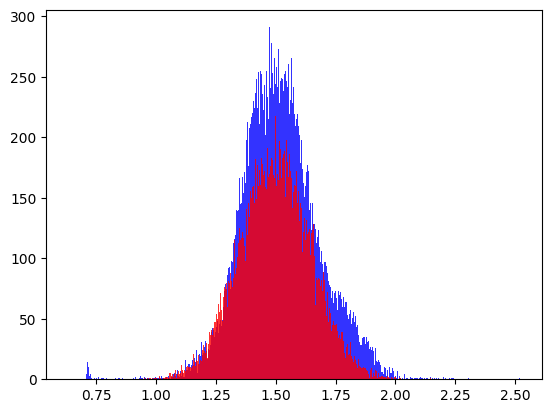

In [94]:
plt.figure()
plt.hist(n, bins=1000, color='blue', alpha=0.8)
plt.hist(np.random.normal(loc=1.5, scale=0.15, size=50267), bins=1000, color='red', alpha=0.8)

In [259]:
model.float()

FromageModel(
  (lm): None
  (input_embeddings): Embedding(50267, 4096)
  (visual_model): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(257, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0): CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
   

In [56]:
inp_image_d = utils.get_image_from_url('https://cdn.britannica.com/60/8160-050-08CCEABC/German-shepherd.jpg')

In [257]:
another_dog = utils.get_image_from_url('https://ichef.bbci.co.uk/news/976/cpsprodpb/17638/production/_124800859_gettyimages-817514614.jpg')

In [260]:
another_dog_no_project = get_visual_embeddings(another_dog, mode='no_projection')

In [270]:
cat = utils.get_image_from_url('https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg')
cat_no_project = get_visual_embeddings(cat, mode='no_projection')

In [82]:
model.lm = None

In [75]:
ve_d_no_project = get_visual_embeddings(inp_image_d, mode='no_projection')

In [76]:
ve_d_no_project = ve_d_no_project[0]

In [71]:
ve_d

tensor([-3.0248,  4.0206,  0.9249,  ..., -0.2175, -0.4823, -0.3924])

In [81]:
ve_d_no_project

torch.Size([1024])

In [83]:
import torch
import torch.nn as nn

In [139]:
class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()

In [179]:
prompt = 'german shepherd dog animal'

In [180]:
targets = tokenizer.encode(prompt, return_tensors='pt')[0,1:]

In [181]:
sparse_targets = torch.zeros(50267).scatter_(0, targets, torch.ones(50267)).to('cuda')

In [182]:
unembed_param = torch.nn.Parameter(data=torch.Tensor(unembed), requires_grad=False).to('cuda')

In [183]:
unembed_param.size()

torch.Size([50267, 4096])

In [325]:
linear_projection = torch.nn.Linear(in_features=1024, out_features=4096, bias=True, device='cuda')
clever_ln = torch.nn.LayerNorm(normalized_shape=4096, elementwise_affine=True, device='cuda')
loss_fn = AsymmetricLossOptimized(gamma_neg=4, gamma_pos=1)

In [326]:
optimizer = torch.optim.AdamW(
    params= [
        {'params': linear_projection.parameters() , 'lr': 0.001, 'weight_decay': 0.001},
        {'params': clever_ln.parameters(), 'lr': 0.001, 'weight_decay': 0}
])

In [327]:
image_vec = ve_d_no_project.to('cuda')
for step in range(0,5000):
    optimizer.zero_grad()
    # Project Image #
    a = linear_projection(image_vec)
    a = clever_ln(a)
    #a = clever_ln(a)
    # Projected Image Must be Matched to Unembeddings #
    emb_a = unembed_param @ a
    # Calculate Loss #
    loss = loss_fn(emb_a, sparse_targets)
    loss.backward()
    optimizer.step()
    if step % 100 == 99:
        print(f"Step:{step} L1 Norm: {a.norm(p=1)} Loss:{loss.item()}")

Step:99 L1 Norm: nan Loss:nan
Step:199 L1 Norm: nan Loss:nan
Step:299 L1 Norm: nan Loss:nan
Step:399 L1 Norm: nan Loss:nan
Step:499 L1 Norm: nan Loss:nan
Step:599 L1 Norm: nan Loss:nan
Step:699 L1 Norm: nan Loss:nan
Step:799 L1 Norm: nan Loss:nan
Step:899 L1 Norm: nan Loss:nan
Step:999 L1 Norm: nan Loss:nan
Step:1099 L1 Norm: nan Loss:nan
Step:1199 L1 Norm: nan Loss:nan
Step:1299 L1 Norm: nan Loss:nan
Step:1399 L1 Norm: nan Loss:nan
Step:1499 L1 Norm: nan Loss:nan
Step:1599 L1 Norm: nan Loss:nan
Step:1699 L1 Norm: nan Loss:nan
Step:1799 L1 Norm: nan Loss:nan
Step:1899 L1 Norm: nan Loss:nan
Step:1999 L1 Norm: nan Loss:nan
Step:2099 L1 Norm: nan Loss:nan
Step:2199 L1 Norm: nan Loss:nan
Step:2299 L1 Norm: nan Loss:nan
Step:2399 L1 Norm: nan Loss:nan
Step:2499 L1 Norm: nan Loss:nan
Step:2599 L1 Norm: nan Loss:nan
Step:2699 L1 Norm: nan Loss:nan
Step:2799 L1 Norm: nan Loss:nan
Step:2899 L1 Norm: nan Loss:nan
Step:2999 L1 Norm: nan Loss:nan
Step:3099 L1 Norm: nan Loss:nan
Step:3199 L1 Norm: 


KeyboardInterrupt



In [ ]:
with torch.no_grad():
    ax = linear_projection(image_vec)
    ax = clever_ln(ax)
    emb_a = unembed_param @ ax

In [ ]:
tokenizer.batch_decode(emb_a.argsort(descending=True)[0:50])

In [ ]:
with torch.no_grad():
    ax = linear_projection(another_dog_no_project.to('cuda')[0])
    ax = clever_ln(ax)
    emb_a = unembed_param @ ax

In [ ]:
tokenizer.batch_decode(emb_a.argsort(descending=True)[0:50])

In [ ]:
with torch.no_grad():
    ax = linear_projection(cat_no_project.to('cuda')[0])
    ax = clever_ln(ax)
    emb_a = unembed_param @ ax

In [ ]:
tokenizer.batch_decode(emb_a.argsort(descending=True)[0:50])

In [ ]:
with torch.no_grad():
    ax = linear_projection(torch.randn(1024).to('cuda'))
    ax = clever_ln(ax)
    emb_a = unembed_param @ ax

In [ ]:
tokenizer.batch_decode(emb_a.argsort(descending=True)[0:50])